# Checking

In [2]:
import torch

In [3]:
torch.cuda.is_available()

True

In [4]:
torch.cuda.device_count()

2

In [5]:
import pandas as pd

In [6]:
df = pd.read_excel("./datasets/SyncData.xlsx")

In [7]:
df

,time_H,Load_H,Res_H,Unnamed: 3,time_V,Load_V,Res_V,Unnamed: 7,time_R,Load_R,Res_R
0,0.000000,-50.492321,-29.348735,NaN,0.000000,-50.491787,-7.147780,NaN,0.000000,-50.492321,-18.590963
1,0.099999,-57.784882,-30.116238,NaN,0.099103,-57.416561,-7.211393,NaN,0.101004,-57.784882,-18.858859
2,0.199998,-65.520958,-30.642679,NaN,0.198207,-65.163918,-7.312418,NaN,0.202008,-65.520958,-19.064215
3,0.299998,-72.881187,-30.999211,NaN,0.297310,-72.527718,-7.399222,NaN,0.303012,-72.881187,-19.256227
4,0.399997,-79.665817,-31.263917,NaN,0.396413,-79.352386,-7.467273,NaN,0.404015,-79.665817,-19.407368
...,...,...,...,...,...,...,...,...,...,...,...
49994,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5049.586555,-10.056506,-9.803270
49995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5049.687559,-15.210902,-10.015795
49996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5049.788562,-21.204048,-10.185714
49997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5049.889566,-27.932865,-10.322576


In [8]:
from sklearn.preprocessing import MinMaxScaler

In [9]:
X = pd.concat([df.loc[:]["time_H"], df.loc[:]["Res_R"]], axis=1)

In [10]:
dataTrain = X[:-24*7]
dataTest = X[-24*7:]

In [11]:
import matplotlib.pyplot as plt

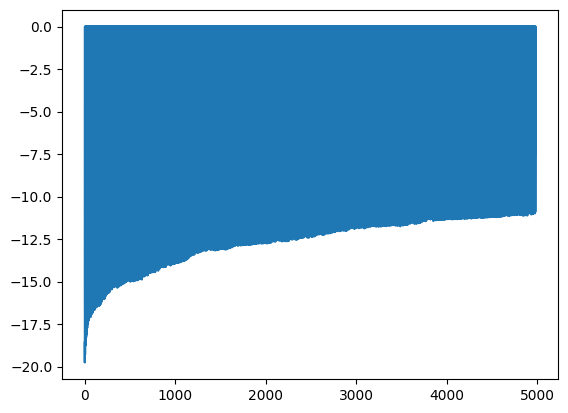

In [12]:
plt.plot(dataTrain.iloc[:, 0], dataTrain.iloc[:, 1])

In [13]:
XTrain = dataTrain[:len(dataTrain) - 1]
TTrain = dataTrain[1:len(dataTrain)]

XTest = dataTest[:len(dataTest) - 1]
TTest = dataTest[1:len(dataTest)]

In [14]:
from sklearn.preprocessing import StandardScaler

In [15]:
std = StandardScaler()
std.fit(XTrain)
XTrain_scaled = std.transform(XTrain)
XTest_scaled = std.transform(XTest)

std.fit(TTrain)
TTrain_scaled = std.transform(TTrain)
TTest_scaled = std.transform(TTest)

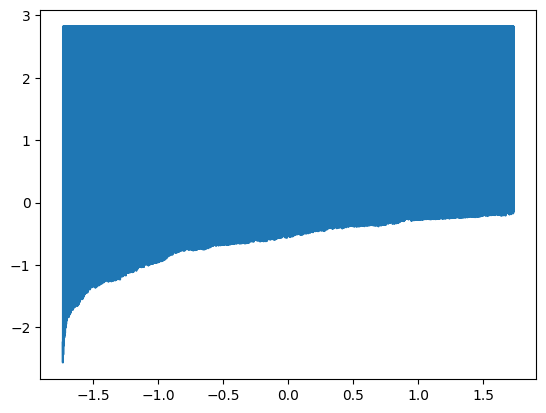

In [16]:
plt.plot(XTrain_scaled[:, 0], XTrain_scaled[:, 1])

In [17]:
from torch.utils.data import DataLoader, Dataset

In [18]:
import numpy as np

In [19]:
class windowDataset(Dataset):
    def __init__(self, y, input_window=80, output_window=20, stride=5):
        L = y.shape[0]
        
        num_samples = (L - input_window - output_window) // stride + 1

        X = np.zeros([input_window, num_samples])
        Y = np.zeros([output_window, num_samples])

        for i in np.arange(num_samples):
            start_x = stride * i
            end_x = start_x + input_window

            X[:, i] = y[start_x:end_x]

            start_y = stride * i + input_window
            end_y = start_y + output_window

            Y[:, i] = y[start_y:end_y]

        X = X.reshape(X.shape[0], X.shape[1], 1).transpose((1, 0, 2))
        Y = Y.reshape(Y.shape[0], Y.shape[1], 1).transpose((1, 0, 2))

        self.x = X
        self.y = Y

        self.len = len(X)

    def __getitem__(self, i):
        return self.x[i], self.y[i]
    
    def __len__(self):
        return self.len

In [20]:
iw = 24 * 14
ow = 24 * 7

In [21]:
import torch
import torch.nn as nn

In [22]:
import math

In [23]:
class TFModel(nn.Module):
    def __init__(self, iw, ow, d_model, nhead, nlayers, dropout=0.5):
        super(TFModel, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=nlayers) 
        self.pos_encoder = PositionalEncoding(d_model, dropout)

        self.encoder = nn.Sequential(
            nn.Linear(1, d_model//2),
            nn.ReLU(),
            nn.Linear(d_model//2, d_model)
        )
        
        self.linear =  nn.Sequential(
            nn.Linear(d_model, d_model//2),
            nn.ReLU(),
            nn.Linear(d_model//2, 1)
        )

        self.linear2 = nn.Sequential(
            nn.Linear(iw, (iw+ow)//2),
            nn.ReLU(),
            nn.Linear((iw+ow)//2, ow)
        ) 

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    
        return mask


    def forward(self, src, srcmask):
        src = self.encoder(src)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src.transpose(0,1), srcmask).transpose(0,1)
        output = self.linear(output)[:,:,0]
        output = self.linear2(output)
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

def gen_attention_mask(x):
    mask = torch.eq(x, 0)
    return mask

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [25]:
import tqdm

In [26]:
def main_worker(gpu, n_gpus):
    epochs = 100
    batch_size = 64
    num_worker = 8
    lr = 1e-4

    batch_size = int(batch_size / n_gpus)
    num_worker = int(num_worker / n_gpus)

    torch.distributed.init_process_group(
        backend='nccl',
        init_method='tcp://221.159.102.58:6006',
        world_size=n_gpus,
        rank=gpu
        )
    
    model = TFModel(24*7*2, 24*7, 512, 8, 4, 0.1)
    
    torch.cuda.set_device(gpu)

    model = model.cuda(gpu)
    model = torch.nn.parallel.DistributedDataParallel(model, device_ids=[gpu])

    train_dataset = windowDataset(XTrain_scaled[:, 1], input_window=iw, output_window=ow, stride=1)
    train_sampler = torch.utils.data.distributed.DistributedSampler(train_dataset)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False, pin_memory=True, num_workers=n_gpus, sampler=train_sampler)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    model.train()

    progress = tqdm(range(epochs))

    for i in progress:
        batchloss = 0.0
        
        for (inputs, outputs) in train_loader:
            optimizer.zero_grad()
            src_mask = model.module.generate_square_subsequent_mask(inputs.shape[1]).to(device)
            result = model(inputs.float().to(device),  src_mask)
            loss = criterion(result, outputs[:,:,0].float().to(device))
            loss.backward()
            optimizer.step()
            batchloss += loss
        progress.set_description("loss: {:0.6f}".format(batchloss.cpu().item() / len(train_loader)))
        print("loss: {:0.6f}".format(batchloss.cpu().item() / len(train_loader)))

In [27]:
n_gpus = torch.cuda.device_count()

In [28]:
import torch.multiprocessing as mp

In [34]:
if __name__ == "__main__":
    world_size = n_gpus
    
    torch.multiprocessing.start_processes(main_worker, nprocs=n_gpus, args=(n_gpus, ))

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/root/anaconda3/envs/papers/lib/python3.8/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/root/anaconda3/envs/papers/lib/python3.8/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'main_worker' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/root/anaconda3/envs/papers/lib/python3.8/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/root/anaconda3/envs/papers/lib/python3.8/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'main_worker' on <module '__main__' (built-in)>


ProcessExitedException: process 0 terminated with exit code 1